In [5]:
# build_sms_spam_model.py
# Lojistik Regresyon ile SMS Spam Modeli
import os
from glob import glob
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

ABS_DATA_GLOB = "kaggle-test.csv"

def load_all_data(file_pattern: str) -> pd.DataFrame:
    dfs = []
    total_initial_rows = 0
    total_dropped_rows = 0

    print(f"Loading data from files matching pattern: {file_pattern}")

    for fp in glob(file_pattern):
        print(f"\nProcessing file: {fp}")
        initial_rows = 0
        try:
            df = pd.read_csv(fp)
            initial_rows = len(df)
            total_initial_rows += initial_rows
            print(f"Initial rows in {fp}: {initial_rows}")

        except Exception as e:
            print(f"Could not read file {fp}: {e}")
            total_dropped_rows += initial_rows # Count rows from unreadable files as dropped
            continue

        current_rows = len(df)
        cols = [c.strip().lower() for c in df.columns]

        # Kolonları 'label','text' olacak şekilde normalize et
        if set(cols) >= {"label", "text"}:
            li = cols.index("label")
            ti = cols.index("text")
            df = df.rename(columns={df.columns[li]: "label", df.columns[ti]: "text"})[["label", "text"]]
            print(f"  - After column normalization: {len(df)} rows")
        elif len(cols) >= 2:
            c0, c1 = df.columns[0], df.columns[1]
            tmp = df[[c0, c1]].rename(columns={c0: "c0", c1: "c1"})
            # Hangi kolonun etiket olduğu sezgisel tespit
            c0_is_label = tmp["c0"].astype(str).str.lower().isin(["spam", "ham"]).mean()
            c1_is_label = tmp["c1"].astype(str).str.lower().isin(["spam", "ham"]).mean()
            if c0_is_label >= c1_is_label:
                df = tmp.rename(columns={"c0": "label", "c1": "text"})
            else:
                df = tmp.rename(columns={"c1": "label", "c0": "text"})
            print(f"  - After column inference and normalization: {len(df)} rows")
        else:
            print(f"  - Skipping file {fp} due to insufficient columns.")
            total_dropped_rows += current_rows
            continue

        # Temizlik
        before_dropna = len(df)
        df = df.dropna(subset=["label", "text"])
        dropped_dropna = before_dropna - len(df)
        total_dropped_rows += dropped_dropna
        print(f"  - Dropped {dropped_dropna} rows with missing label/text. Remaining: {len(df)}")


        df["label"] = df["label"].astype(str).str.strip().str.lower()
        # 'norm' veya 'normal' etiketlerini ham olarak kabul et
        df["label"] = df["label"].replace({"norm": "ham", "normal": "ham"})
        df["text"] = df["text"].astype(str).str.strip()

        before_label_filter = len(df)
        df = df[df["label"].isin(["spam", "ham"])]
        dropped_label_filter = before_label_filter - len(df)
        total_dropped_rows += dropped_label_filter
        print(f"  - Dropped {dropped_label_filter} rows with invalid labels. Remaining: {len(df)}")


        # Çok kısa/boş mesajları at
        before_len_filter = len(df)
        df = df[df["text"].str.len() >= 2]
        dropped_len_filter = before_len_filter - len(df)
        total_dropped_rows += dropped_len_filter
        print(f"  - Dropped {dropped_len_filter} rows with short text. Remaining: {len(df)}")

        dfs.append(df[["label", "text"]])

    if not dfs:
        raise ValueError("Veri bulunamadı. Lütfen 'Test/*.csv' altında uygun CSV dosyaları bulunsun.")

    data = pd.concat(dfs, ignore_index=True)

    before_duplicates = len(data)
    data.drop_duplicates(subset=["label", "text"], inplace=True)
    dropped_duplicates = before_duplicates - len(data)
    total_dropped_rows += dropped_duplicates
    print(f"\nDropped {dropped_duplicates} duplicate rows. Total remaining after cleaning and de-duplication: {len(data)}")

    print(f"\nSummary: Total initial rows across all files: {total_initial_rows}")
    print(f"Summary: Total rows dropped during processing: {total_dropped_rows}")
    print(f"Summary: Final rows used for training: {len(data)}")

    return data

def basic_text_clean(s: str) -> str:
    # Basit URL ve fazla boşluk temizliği; TF-IDF öncesi hafif normalizasyon
    s = re.sub(r"(?i)\b(?:https?://|http://|www\.)\S+\b", " URL ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def build_pipeline() -> Pipeline:
    return Pipeline(
        steps=[
            ("tfidf", TfidfVectorizer(
                preprocessor=basic_text_clean,
                lowercase=True,
                strip_accents="unicode",
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.9,
                token_pattern=r"(?u)\b\w\w+\b",
            )),
            ("clf", LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                solver="liblinear",
                random_state=42,
            )),
        ]
    )

def train_and_eval(df: pd.DataFrame):
    X = df["text"].astype(str).values
    y = (df["label"] == "spam").astype(int).values  # spam=1, ham=0

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    pipe = build_pipeline()
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=["ham(0)", "spam(1)"]))

    return pipe

def predict_sms_01(model: Pipeline, sms_text: str) -> int:
    return int(model.predict([sms_text])[0])

def main():
    df = load_all_data(ABS_DATA_GLOB)
    print("\nFinal data loaded. Total examples:", len(df), "| Class distribution:\n", df["label"].value_counts())
    model = train_and_eval(df)

    # Modeli kaydet
    out_dir = "output"
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, "sms_spam_model.joblib")

    joblib.dump(model, out_path)
    print(f"\nModel saved: {out_path}")

    # Örnek tahmin
    example_sms = "Tebrikler! 5000 TL hediye çeki kazandınız. Hemen tıklayın: http://ornek.link"
    print("\nExample prediction:", predict_sms_01(model, example_sms))  # 1 beklenir

if __name__ == "__main__":
    main()

Loading data from files matching pattern: kaggle-test.csv

Processing file: kaggle-test.csv
Initial rows in kaggle-test.csv: 5768
  - After column normalization: 5768 rows
  - Dropped 0 rows with missing label/text. Remaining: 5768
  - Dropped 0 rows with invalid labels. Remaining: 5768
  - Dropped 1 rows with short text. Remaining: 5767

Dropped 19 duplicate rows. Total remaining after cleaning and de-duplication: 5748

Summary: Total initial rows across all files: 5768
Summary: Total rows dropped during processing: 20
Summary: Final rows used for training: 5748

Final data loaded. Total examples: 5748 | Class distribution:
 label
spam    3034
ham     2714
Name: count, dtype: int64
              precision    recall  f1-score   support

      ham(0)       0.93      0.98      0.96       543
     spam(1)       0.98      0.94      0.96       607

    accuracy                           0.96      1150
   macro avg       0.96      0.96      0.96      1150
weighted avg       0.96      0.96   

In [6]:
# Örnek tahmin
import joblib
example_sms2 = "Bu aksam marketten ekmek ve sut alir misin?"

# Modeli otomatik yükle (daha önce yüklenmediyse)
if 'loaded_model' not in globals():
    loaded_model = joblib.load("output/sms_spam_model.joblib")

print("\nExample prediction:", predict_sms_01(loaded_model, example_sms2))  # 1 spam 0 değil


Example prediction: 0


In [7]:
# Step 1 & 2: Load and prepare the test data
TEST_DATA_GLOB = "seed.csv"
test_df = load_all_data(TEST_DATA_GLOB)

X_test_new = test_df["text"].astype(str).values
y_test_new = (test_df["label"] == "spam").astype(int).values # spam=1, ham=0

print("\nTest data loaded. Total examples:", len(test_df), "| Class distribution:\n", test_df["label"].value_counts())

Loading data from files matching pattern: seed.csv

Processing file: seed.csv
Initial rows in seed.csv: 121
  - After column normalization: 121 rows
  - Dropped 0 rows with missing label/text. Remaining: 121
  - Dropped 0 rows with invalid labels. Remaining: 121
  - Dropped 0 rows with short text. Remaining: 121

Dropped 0 duplicate rows. Total remaining after cleaning and de-duplication: 121

Summary: Total initial rows across all files: 121
Summary: Total rows dropped during processing: 0
Summary: Final rows used for training: 121

Test data loaded. Total examples: 121 | Class distribution:
 label
spam    89
ham     32
Name: count, dtype: int64


In [8]:
# Step 3: Load the saved model
model_path = "output/sms_spam_model.joblib"
loaded_model = joblib.load(model_path)
print(f"\nModel loaded from: {model_path}")


Model loaded from: output/sms_spam_model.joblib


In [9]:
# Yardımcı: Olasılık ve eşik ile SMS tahmini (0/1)
import numpy as np


def predict_with_proba(model, text: str, threshold: float = 0.5):
    proba = model.predict_proba([text])[0]
    p_ham, p_spam = float(proba[0]), float(proba[1])
    pred = 1 if p_spam >= threshold else 0
    return {"pred": pred, "p_spam": p_spam, "p_ham": p_ham, "threshold": threshold}


# Kullanım örnekleri (önce 'loaded_model' hücresini çalıştırın)
examples = [
    "Tebrikler! 5000 TL hediye çeki kazandınız. Hemen tıklayın: http://ornek.link",
    "Bu aksam marketten ekmek ve sut alir misin?",
]
for txt in examples:
    res = predict_with_proba(loaded_model, txt, threshold=0.5)
    print(
        f"Text: {txt}\n -> pred={res['pred']} (spam=1), p_spam={res['p_spam']:.3f}, p_ham={res['p_ham']:.3f}\n"
    )


Text: Tebrikler! 5000 TL hediye çeki kazandınız. Hemen tıklayın: http://ornek.link
 -> pred=1 (spam=1), p_spam=0.895, p_ham=0.105

Text: Bu aksam marketten ekmek ve sut alir misin?
 -> pred=0 (spam=1), p_spam=0.379, p_ham=0.621



In [10]:
# Eğitim ve test arasında metin örtüşmesi (leakage) kontrolü
TRAIN_PATTERN = "kaggle-test.csv"
TEST_PATTERN = "seed.csv"

train_df_tmp = load_all_data(TRAIN_PATTERN)
test_df_tmp = load_all_data(TEST_PATTERN)

overlap_texts = set(train_df_tmp["text"]).intersection(set(test_df_tmp["text"]))
print(f"Train-Test ortak mesaj sayısı: {len(overlap_texts)}")

# İsterseniz testten ortakları çıkarıp yeniden değerlendirilebilir:
if len(overlap_texts) > 0:
    test_df_no_overlap = test_df_tmp[~test_df_tmp["text"].isin(overlap_texts)].copy()
    X_t = test_df_no_overlap["text"].astype(str).values
    y_t = (test_df_no_overlap["label"] == "spam").astype(int).values
    y_p = loaded_model.predict(X_t)
    print("\nClassification report (test overlap çıkarıldı):")
    print(classification_report(y_t, y_p, target_names=["ham(0)", "spam(1)"]))
else:
    print("Örtüşme bulunmadı.")


Loading data from files matching pattern: kaggle-test.csv

Processing file: kaggle-test.csv
Initial rows in kaggle-test.csv: 5768
  - After column normalization: 5768 rows
  - Dropped 0 rows with missing label/text. Remaining: 5768
  - Dropped 0 rows with invalid labels. Remaining: 5768
  - Dropped 1 rows with short text. Remaining: 5767

Dropped 19 duplicate rows. Total remaining after cleaning and de-duplication: 5748

Summary: Total initial rows across all files: 5768
Summary: Total rows dropped during processing: 20
Summary: Final rows used for training: 5748
Loading data from files matching pattern: seed.csv

Processing file: seed.csv
Initial rows in seed.csv: 121
  - After column normalization: 121 rows
  - Dropped 0 rows with missing label/text. Remaining: 121
  - Dropped 0 rows with invalid labels. Remaining: 121
  - Dropped 0 rows with short text. Remaining: 121

Dropped 0 duplicate rows. Total remaining after cleaning and de-duplication: 121

Summary: Total initial rows acros

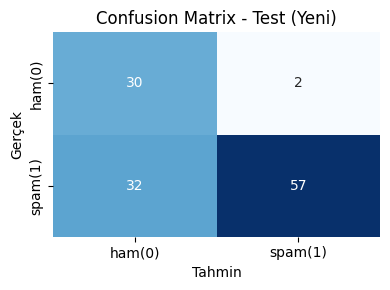

In [11]:
# Karışıklık matrisi (Confusion Matrix) görselleştirme
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Yoksalar bağımlı değişkenleri üret
if 'y_pred_new' not in globals():
    if 'loaded_model' not in globals():
        loaded_model = joblib.load("output/sms_spam_model.joblib")
    if 'X_test_new' not in globals() or 'y_test_new' not in globals():
        TEST_DATA_GLOB = "seed.csv"
        test_df = load_all_data(TEST_DATA_GLOB)
        X_test_new = test_df["text"].astype(str).values
        y_test_new = (test_df["label"] == "spam").astype(int).values
    y_pred_new = loaded_model.predict(X_test_new)

cm = confusion_matrix(y_test_new, y_pred_new)
plt.figure(figsize=(4, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["ham(0)", "spam(1)"],
    yticklabels=["ham(0)", "spam(1)"],
)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix - Test (Yeni)")
plt.tight_layout()
plt.show()


In [13]:
# Step 4 & 5: Make predictions and evaluate the model
y_pred_new = loaded_model.predict(X_test_new)

print("\nClassification Report on Test Data:")
print(classification_report(y_test_new, y_pred_new, target_names=["ham(0)", "spam(1)"]))


Classification Report on Test Data:
              precision    recall  f1-score   support

      ham(0)       0.48      0.94      0.64        32
     spam(1)       0.97      0.64      0.77        89

    accuracy                           0.72       121
   macro avg       0.72      0.79      0.70       121
weighted avg       0.84      0.72      0.74       121

